<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Langgraph/module-2/2_4_trim_filter_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Filtering and trimming messages

## Review
Now, we have a deeper understanding of a few things:

- How to customize the graph state schema
- How to define custom state reducers
- How to use multiple graph state schemas

## Goals
Now, we can start using these concepts with models in LangGraph!

In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_google_genai

In [4]:
from google.colab import userdata

import os
os.environ["GOOGLE_API_KEY"] = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/observability/concepts).

We'll log to a project, langchain-academy.

In [5]:
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state
First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Rizwan"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
llm.invoke(messages)

AIMessage(content='That\'s a great starting point!  Whales are a fascinating group, but the ocean holds a vast diversity of other mammals.  To suggest further research, it helps to know what aspects of whales interest you most.  Do you like their size, their social behavior, their migration patterns, their vocalizations, their conservation status, etc.?  Knowing this will help me tailor suggestions.\n\nHowever, here\'s a broad overview of other ocean mammal groups you should consider researching, categorized for easier digestion:\n\n\n**1. Marine Mammals closely related to Whales (Order Cetartiodactyla):**\n\n* **Dolphins and Porpoises (Family Delphinidae & others):**  Incredibly diverse group with varying sizes, social structures, and feeding strategies.  Researching them will expose you to a wide range of adaptations.\n* **Porpoises (Family Phocoenidae):** Often smaller and less flamboyant than dolphins, but equally fascinating.\n* **Dolphins and Porpoises (Oceanic and River Dolphins

We can run our chat model in a simple graph with `MessagesState`.

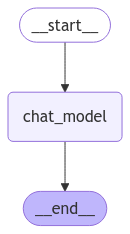

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there's a fascinating world of other ocean mammals to explore!  Here are some groups and examples, categorized for easier learning:

**1. Seals, Sea Lions, and Walruses (Pinnipeds):**

* **Seals:**  Generally smaller, lack external ear flaps (pinnae), and have a more streamlined body for swimming.  There are several types, including harbor seals, harp seals, and elephant seals (which are surprisingly large!).  Learn about their different adaptations for swimming and hunting.
* **Sea Lions:** Larger than most seals, possess external ear flaps, and have more prominent foreflippers used for "walking

In [10]:
async for m in graph.astream_events({'messages': messages}, version="v2"): # The version argument is now correctly passed as a keyword argument.
      print(m)
      print("\n--------------\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='884419ab-c043-4104-8ced-65eeec84b955'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Rizwan', id='98136521-ae64-4d39-883e-d0fa2a34b998')]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '1c53b457-c848-4c47-a64d-67bbf201109e', 'metadata': {}, 'parent_ids': []}

--------------

{'event': 'on_chain_start', 'data': {'input': {'messages': [AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='884419ab-c043-4104-8ced-65eeec84b955'), HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Rizwan', id='98136521-ae64-4d39-883e-d0fa2a34b998')]}}, 'name': '__start__',

## Reducer
A practical challenge when working with messages is managing long-running conversations.

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

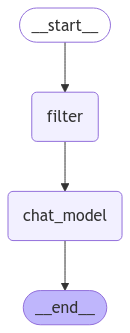

In [11]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState) -> MessagesState:
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState) -> MessagesState:
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Rizwan", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Rizwan", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  There's a whole underwater world of fascinating ocean mammals beyond whales.  To suggest some others, it helps to know what aspects of whales interest you.  Are you interested in:

* **Size and behavior?**  If so, consider **seals**, **sea lions**, and **walruses**.  They display diverse social structures and hunting strategies.  Elephants seals are especially interesting for their extreme diving abilities.

* **Intelligence and social complexity?**  Dolphins are a classic example, but also look into **porpoises**, which are often smaller and less showy but still highly

## Filtering messages
If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

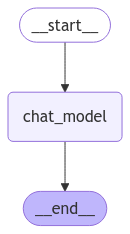

In [14]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph: CompiledStateGraph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [17]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Rizwan"))

In [18]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Rizwan

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  There's a whole underwater world of fascinating ocean mammals beyond whales.  To suggest some others, it helps to know what aspects of whales interest you.  Are you interested in:

* **Size and behavior?**  If so, consider **seals**, **sea lions**, and **walruses**.  They display diverse social structures and hunting strategies.  Elephants seals are especially interesting for th

In [19]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Rizwan

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Rizwan

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great you're familiar with whales!  There's a whole underwater world of fascinating ocean mammals beyond whales.  To suggest some others, it helps to know what aspects of whales interest you.  Are you interested in:

* **Size and behavior?**  If so, consider **seals**, **sea lions**, and **walruses**.  They display diverse social structures and hunting strategies.  Elephants seals are especially interesting for th

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:


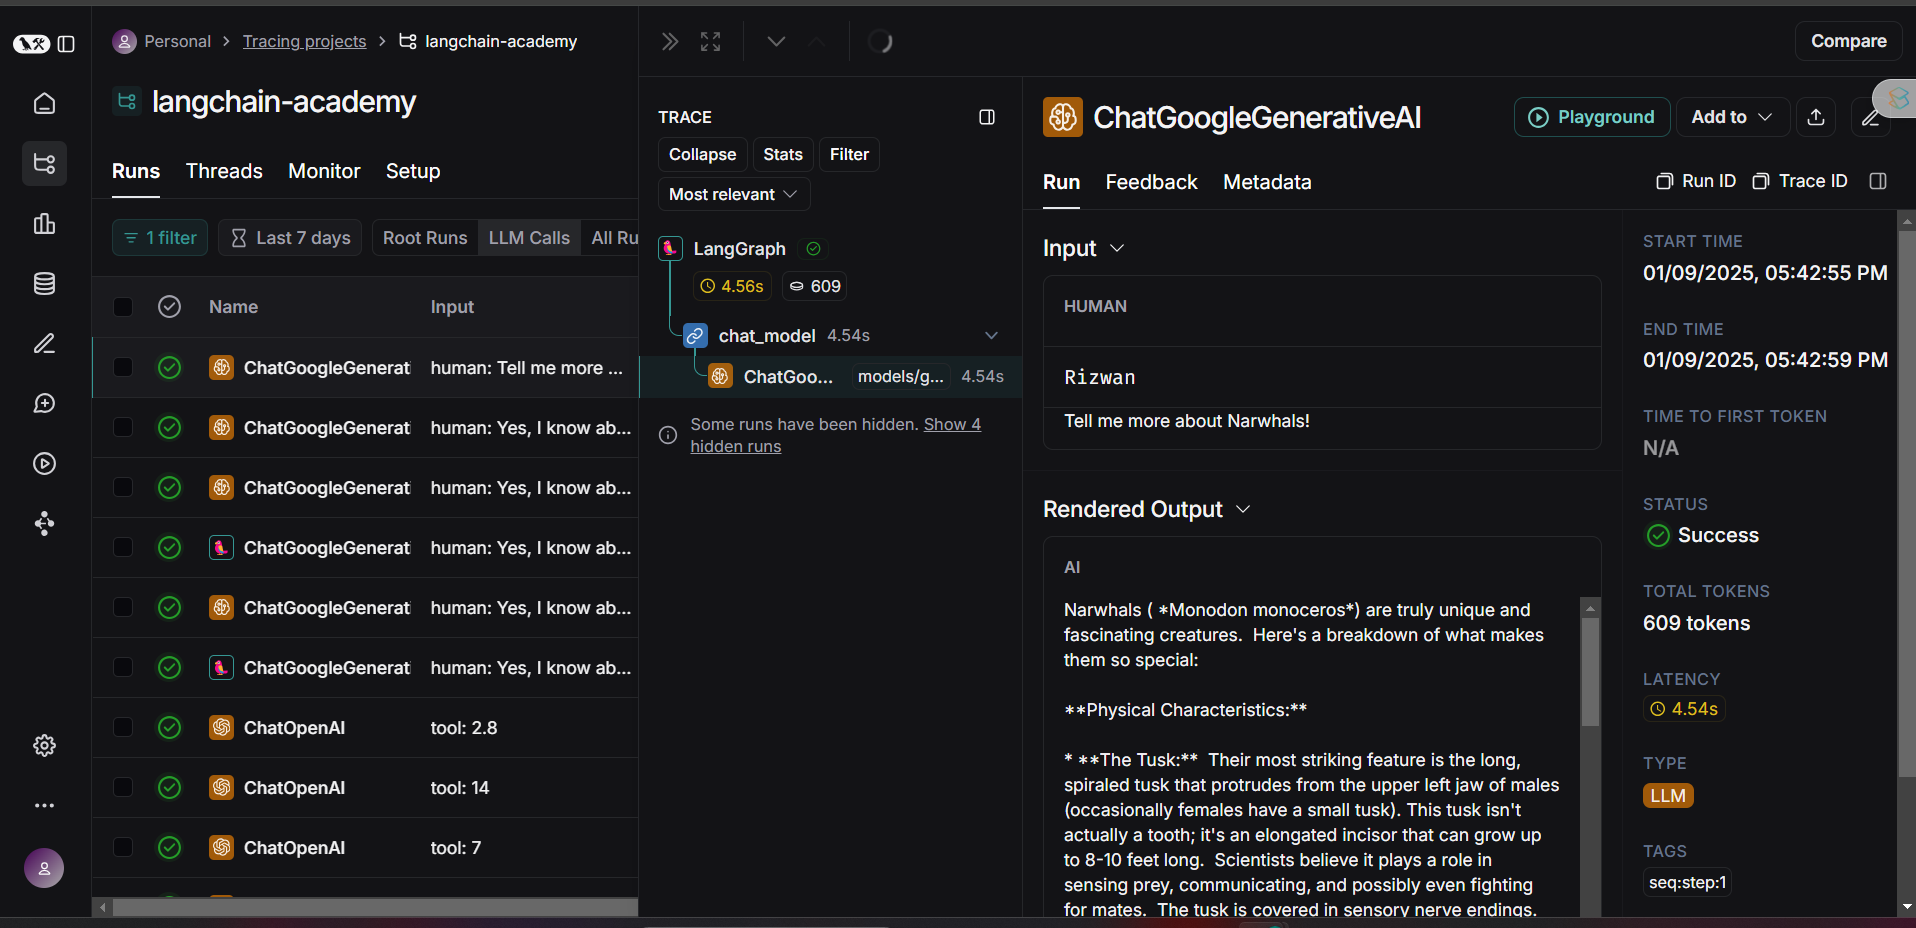